# Classification

In [1]:
import experiments.nns.simplenet.simplenet
from experiments.nns.simplenet.simplenet import SimpleNet
from experiments.nns.cnn.cnn import CNN
from experiments.nns.lenet.lenet import LeNet
import torch.optim as optim
import torch.nn as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
import torch
import copy
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


notebook_directory = os.path.dirname(os.path.abspath("mswag_classification_v2.ipynb"))
# Navigate to the parent folder (assuming "usr" and "home" are at the same level)
parent_directory = os.path.abspath(os.path.join(notebook_directory, "..","..","..","..","..","..",".."))

# Construct the path to the ImageNet directory
mnist_directory = os.path.abspath(os.path.join(parent_directory, "/usr/data1/vision/data/"))

mnist_directory = os.path.abspath(os.path.join(parent_directory, "/usr/data1/vision/data/"))

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


# Load the MNIST training dataset
train_dataset = datasets.MNIST(root=mnist_directory, train=True, download=False, transform=transform)


# Assuming you have these variables defined
# mnist_directory, transform, transform_rotation


# Load the MNIST test dataset
test_dataset = datasets.MNIST(root=mnist_directory, train=False, download=False, transform=transform)
# rotated_test_dataset = datasets.MNIST(root=mnist_directory, train=False, download=False, transform=transform_rotation)

# # Select 1/10 samples of each class for both train and test datasets
# train_subset_indices = []
# test_subset_indices = []

# class_indices = [i for i in range(len(test_dataset)) if test_dataset[i][1] == test_class]
# for c in range(10):
#     class_indices = [i for i in range(len(train_dataset)) if train_dataset[i][1] == c]
#     train_subset_indices.extend(class_indices[:len(class_indices)//10])
    
#     class_indices = [i for i in range(len(test_dataset)) if test_dataset[i][1] == c]
#     test_subset_indices.extend(class_indices[:len(class_indices)//10])

# Create the subset with 1/10th of the original size for each class
# train_subset = torch.utils.data.Subset(train_dataset, train_subset_indices)
# rotated_train_subset = torch.utils.data.Subset(rotated_train_dataset, train_subset_indices)


# # Save the subset indices inside mnist_directory
train_idx_path = os.path.join(mnist_directory, "train_indices.pth")
# rotated_idx_sub_path = os.path.join(mnist_directory, "rotated_train_indices.pth")
# test_idx_path = os.path.join(mnist_directory, "test_indices.pth")
# rotated_test_idx_sub_path = os.path.join(mnist_directory, "rotated_test_indices.pth")
# torch.save(train_subset_indices, train_idx_path)
# torch.save(train_subset_indices, rotated_idx_sub_path)
# torch.save(test_subset_indices, test_idx_path)


# Load the subset indices from mnist_directory
loaded_train_indices = torch.load(train_idx_path)
# loaded_test_indices = torch.load(test_idx_path)

# Create the subset using the loaded indices
loaded_train_subset = torch.utils.data.Subset(train_dataset, loaded_train_indices)
# loaded_test_subset = torch.utils.data.Subset(test_dataset, loaded_test_indices)

In [3]:
import torch
import copy
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from experiments.nns.bdl import CustomMNISTDataset

# Example usage:
selected_numbers = [1]
# Include rotation in the transformation
# transform = transforms.Compose([
#     transforms.RandomRotation(degrees=(-180, 180), fill=(0,)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# rotation_angles = [0, 15, 30, 45, 60, 75, 80, 95]
rotation_angles = []
for i in range(12):
    rotation_angles.append(i*5.5)
def get_rotated_mnist_dataset(degrees):
    rotate_transform = transforms.Compose([
            transforms.RandomRotation(degrees=(degrees, degrees), fill=(0,)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    rotated_dataset = CustomMNISTDataset(root=mnist_directory, numbers=selected_numbers, train=False, transform=rotate_transform)
    rotated_loader = DataLoader(rotated_dataset, batch_size=512, shuffle=False)
    return rotated_dataset, rotated_loader
rotated_datasets = []
rotated_loaders = []

for angle in rotation_angles:
    rotated_dataset, rotated_loader = get_rotated_mnist_dataset(angle)
    rotated_datasets.append(rotated_dataset)
    rotated_loaders.append(rotated_loader)


test_dataset = CustomMNISTDataset(root=mnist_directory, numbers=selected_numbers, train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [4]:
# Create data loaders
batch_size = 512
train_loader = DataLoader(loaded_train_subset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(loaded_test_subset, batch_size=512, shuffle=False)

In [5]:
import torch
import push.bayes.swag
from torch.utils.data import DataLoader

# ensemble = push.bayes.ensemble.train_deep_ensemble(
#         train_loader,
#         torch.nn.CrossEntropyLoss(),
#         epochs,
#         LeNet,
#         num_devices=2,
#         num_ensembles=100,
#         cache_size=25
#     )

swag_epochs = 10
pretrain_epochs = 40
loss_fn = torch.nn.CrossEntropyLoss()

mswag = push.bayes.swag.train_mswag(
    train_loader,
    loss_fn,
    pretrain_epochs,
    swag_epochs,
    LeNet,
    num_devices=2,
    num_models = 100,
)


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, loss=tensor(0.9662)]


In [6]:
outputs = []
for loader in rotated_loaders:
    outputs.append(mswag.posterior_pred(loader,f_reg=False, mode=["mode","logits","prob"]))

In [7]:
def get_mode(output, mode):
    return output[mode]
    
# get_mode(two_model_outputs0, "logits")[:,:,(1,3,7)][0][:,(0)]

In [8]:
len(get_mode(outputs[0], "logits"))

10

In [9]:
# Display rotated images
# num_images_to_display = 
idx_image_to_display = 4
imgs = []
lbls = []
for dataset in rotated_datasets:
    rotated_loader_small = DataLoader(dataset, batch_size=512, shuffle=False)
    for images, labels in rotated_loader_small:
        imgs.append(images[idx_image_to_display])
        lbls.append(labels[idx_image_to_display])
        break

In [10]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def offset_image(coord, i, ax, low_img, low_index, zoom):
    '''from mnist_classification_mc_dropout.ipynb [1]'''
    img = imgs[i]
    im = OffsetImage(img.squeeze(), zoom=zoom)
    im.image.axes = ax

    ab = AnnotationBbox(
        im,
        (coord, low_img),
        xybox=(0.0, low_index),
        frameon=False,
        boxcoords="offset points",
    )
    ax.add_artist(ab)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


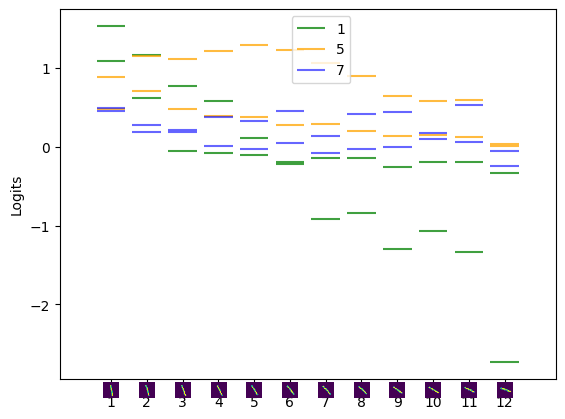

In [11]:

fig, ax = plt.subplots(1)
zoom = 0.4
# else:
#     plt.rcParams["font.size"] = 16
#     fig, ax = plt.subplots(1, figsize=(12, 6))
#     zoom = 1
index = jnp.arange(len(outputs))
for i, output in enumerate(outputs):
    '''plot generated from mnist_classification_mc_dropout.ipynb [1]'''
    ax.eventplot(
        get_mode(output, "logits")[:,:,(1,3,7)][idx_image_to_display][:,(0)],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="green",
        alpha=0.75,
    )
    ax.eventplot(
        get_mode(output, "logits")[:,:,(1,3,7)][idx_image_to_display][:,(1)],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="orange",
        alpha=0.75,
    )
    ax.eventplot(
        get_mode(output, "logits")[:,:,(1,3,7)][idx_image_to_display][:,(2)],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="blue",
        alpha=0.6,
    )

ax.set_xticks(index)
ax.set_xticklabels(index + 1)
ax.tick_params(axis="x", which="major", pad=8)
ax.set_ylabel("Logits")
l, h = ax.get_ylim()
for i in index:
    offset_image(i, i, ax, l, l - 5, zoom)
ax.legend(["1", "5", "7"], bbox_to_anchor=(0.6, 1.0))
# sns.despine()
# savefig("mnist_softmax_input", tight_bbox=True, pad=1)
plt.show()

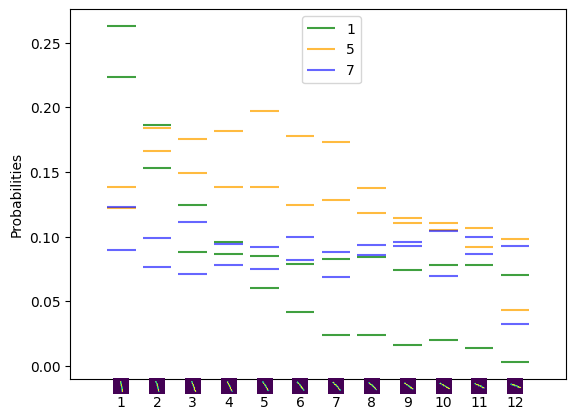

In [12]:
fig, ax = plt.subplots(1)
zoom = 0.4
# else:
#     plt.rcParams["font.size"] = 16
#     fig, ax = plt.subplots(1, figsize=(12, 6))
#     zoom = 1
index = jnp.arange(len(outputs))
for i, output in enumerate(outputs):
    '''plot generated from mnist_classification_mc_dropout.ipynb [1]'''
    ax.eventplot(
        get_mode(output, "prob")[:,:,(1,3,7)][idx_image_to_display][:,(0)],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="green",
        alpha=0.75,
    )
    ax.eventplot(
        get_mode(output, "prob")[:,:,(1,3,7)][idx_image_to_display][:,(1)],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="orange",
        alpha=0.75,
    )
    ax.eventplot(
        get_mode(output, "prob")[:,:,(1,3,7)][idx_image_to_display][:,(2)],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="blue",
        alpha=0.6,
    )

ax.set_xticks(index)
ax.set_xticklabels(index + 1)
ax.tick_params(axis="x", which="major", pad=8)
ax.set_ylabel("Probabilities")
l, h = ax.get_ylim()
for i in index:
    offset_image(i, i, ax, l, l - 5, zoom)
ax.legend(["1", "5", "7"], bbox_to_anchor=(0.6, 1.0))
# sns.despine()
# savefig("mnist_softmax_input", tight_bbox=True, pad=1)
plt.show()

[1] Kevin Murphy. Probabilistic Machine Learning Advanced Topics. Chapter 17. The MIT Press: Adaptive computation and machine learning series (2023). Cambridge, Massachusetts.